In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('subset.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 137 entries, DeviceName to udp.time_relative
dtypes: bool(6), float64(64), int64(5), object(62)
memory usage: 206.0+ KB
None


In [2]:
df.head()

,DeviceName,Frame_length,Frame_protocols_in,arp.dst_hw_mac,arp.dst_proto_ipv4,arp.hw_size,arp.hw_type,arp.opcode,arp.proto_size,arp.proto_type,...,udp.checksum,udp.checksum_status,udp.dstport,udp.length,udp.port,udp.srcport,udp.stream,udp.stream_pnum,udp.time_delta,udp.time_relative
0,Dropcam,156,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TPLink Router Bridge LAN (Gateway),66,eth:ethertype:ip:tcp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dropcam,284,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dropcam,156,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TPLink Router Bridge LAN (Gateway),90,eth:ethertype:ip:udp:ntp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0xb440,2.0,4967.0,56.0,123.0,123.0,0.0,1.0,0.0,0.0


In [3]:
print("Original shape:", df.shape)
df = df.drop(['eth.addr', 'eth.addr_oui', 'eth.addr_oui_resolved', 'eth.addr_resolved',
              'eth.dst', 'eth.dst_oui_resolved', 'eth.dst_resolved', 'eth.src', 'eth.src_ig',
              'eth.src_lg', 'eth.src_oui', 'eth.src_oui_resolved', 'eth.src_resolved', 'ip.addr',
              'ip.dst', 'ip.dst_host', 'ip.host', 'ip.src', 'ip.src_host', 'arp.dst_hw_mac',
              'arp.dst_proto_ipv4', 'arp.src_hw_mac', 'arp.src_proto_ipv4'], axis=1)
print("Shape after removing unreliable data:", df.shape)

Original shape: (200, 137)
Shape after removing unreliable data: (200, 114)


In [4]:
# TEMPORARY: DROP tcp.analysis_initial_rtt WITH NO VALUES (OTHERWISE KILLS IMPUTER)
df = df.drop('tcp.analysis_initial_rtt', axis=1)

In [5]:
print("Empty values in the dataset:")
print(df.isna().sum().sort_values())
print("\nTotal:", df.isna().sum().sum())

Empty values in the dataset:
DeviceName         0
eth.type           0
eth.stream         0
eth.ig             0
eth.dst_oui        0
                ... 
icmp.ident_le    182
icmp.seq         182
icmp.seq_le      182
icmp.type        182
icmp.data        194
Length: 113, dtype: int64

Total: 10416


In [6]:
# Impute missing values
from sklearn.impute import SimpleImputer

# For numerical columns, replace empty values with the mean
num_imputer = SimpleImputer(strategy='mean')
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# For categorical columns, replace empty values with the mode
cat_imputer = SimpleImputer(strategy="most_frequent")
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

print("Empty values after imputing:")
print(df.isna().sum())
print("\nTotal:", df.isna().sum().sum())

Empty values after imputing:
DeviceName            0
Frame_length          0
Frame_protocols_in    0
arp.hw_size           0
arp.hw_type           0
                     ..
udp.srcport           0
udp.stream            0
udp.stream_pnum       0
udp.time_delta        0
udp.time_relative     0
Length: 113, dtype: int64

Total: 0


In [ ]:
# Feature scaling for numerical columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df[numerical_cols].head()

,Frame_length,arp.hw_size,arp.hw_type,arp.opcode,arp.proto_size,eth.dst_oui,eth.stream,icmp.checksum_status,icmp.code,icmp.data_len,...,tls.record_length,udp.checksum_status,udp.dstport,udp.length,udp.port,udp.srcport,udp.stream,udp.stream_pnum,udp.time_delta,udp.time_relative
0,0.476076,0.0,0.0,0.0,0.0,-0.454880,-0.824769,0.0,0.0,-6.258676e-15,...,-5.104766e-01,4.638361e-15,-3.123187e-16,0.00000,0.000000,0.000000,1.344080e-15,-6.879800e-16,3.079526e-16,0.000000
1,-0.537690,0.0,0.0,0.0,0.0,-0.027733,-0.824769,0.0,0.0,-6.258676e-15,...,-2.266971e-15,4.638361e-15,-3.123187e-16,0.00000,0.000000,0.000000,1.344080e-15,-6.879800e-16,3.079526e-16,0.000000
2,1.917877,0.0,0.0,0.0,0.0,-0.454880,-0.824769,0.0,0.0,-6.258676e-15,...,-5.104766e-01,4.638361e-15,-3.123187e-16,0.00000,0.000000,0.000000,1.344080e-15,-6.879800e-16,3.079526e-16,0.000000
3,0.476076,0.0,0.0,0.0,0.0,-0.454880,-0.824769,0.0,0.0,-6.258676e-15,...,-5.104766e-01,4.638361e-15,-3.123187e-16,0.00000,0.000000,0.000000,1.344080e-15,-6.879800e-16,3.079526e-16,0.000000
4,-0.267353,0.0,0.0,0.0,0.0,2.431296,-0.570994,0.0,0.0,-6.258676e-15,...,-2.266971e-15,-8.703883e-01,-1.787573e+00,-2.64293,-4.001521,-4.001521,-6.305416e+00,-2.581989e+00,-1.246790e+00,-1.547047


In [ ]:
# Feature encoding for categorical columns
from sklearn.preprocessing import OneHotEncoder

categorical_features = categorical_cols.drop(['DeviceName'])
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_features])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
X = pd.concat([df, one_hot_df], axis=1).drop(categorical_cols, axis=1)

print(f"Encoded features (X) ({len(X.columns)}):\n", list(X.columns))

Encoded features (X) (849):
 ['Frame_length', 'arp.hw_size', 'arp.hw_type', 'arp.opcode', 'arp.proto_size', 'eth.dst_oui', 'eth.stream', 'icmp.checksum_status', 'icmp.code', 'icmp.data_len', 'icmp.ident', 'icmp.ident_le', 'icmp.seq', 'icmp.seq_le', 'icmp.type', 'ip.checksum_status', 'ip.dsfield_dscp', 'ip.dsfield_ecn', 'ip.frag_offset', 'ip.hdr_len', 'ip.len', 'ip.proto', 'ip.stream', 'ip.ttl', 'ip.version', 'tcp._ws_expert_group', 'tcp._ws_expert_severity', 'tcp.ack', 'tcp.ack_raw', 'tcp.analysis_ack_rtt', 'tcp.analysis_acks_frame', 'tcp.analysis_bytes_in_flight', 'tcp.analysis_push_bytes_sent', 'tcp.checksum_status', 'tcp.completeness', 'tcp.dstport', 'tcp.hdr_len', 'tcp.len', 'tcp.nxtseq', 'tcp.option_kind', 'tcp.option_len', 'tcp.options_nop', 'tcp.options_timestamp_tsecr', 'tcp.options_timestamp_tsval', 'tcp.port', 'tcp.seq', 'tcp.seq_raw', 'tcp.srcport', 'tcp.stream', 'tcp.time_delta', 'tcp.time_relative', 'tcp.urgent_pointer', 'tcp.window_size', 'tcp.window_size_scalefactor', 't

In [36]:
y = df['DeviceName']
print('Label (y):', y.name)
print(f"Classes ({len(y.unique())}):\n", y.unique())

Label (y): DeviceName
Classes (12):
 ['Dropcam' 'TPLink Router Bridge LAN (Gateway)' 'Netatmo Welcome '
 'Amazon Echo' 'Smart Things' 'Withings Smart Baby Monitor '
 'Samsung SmartCam ' 'TP-Link Day Night Cloud camera '
 'Belkin Wemo switch ' 'Triby Speaker' 'HP Printer'
 'Belkin wemo motion sensor ']


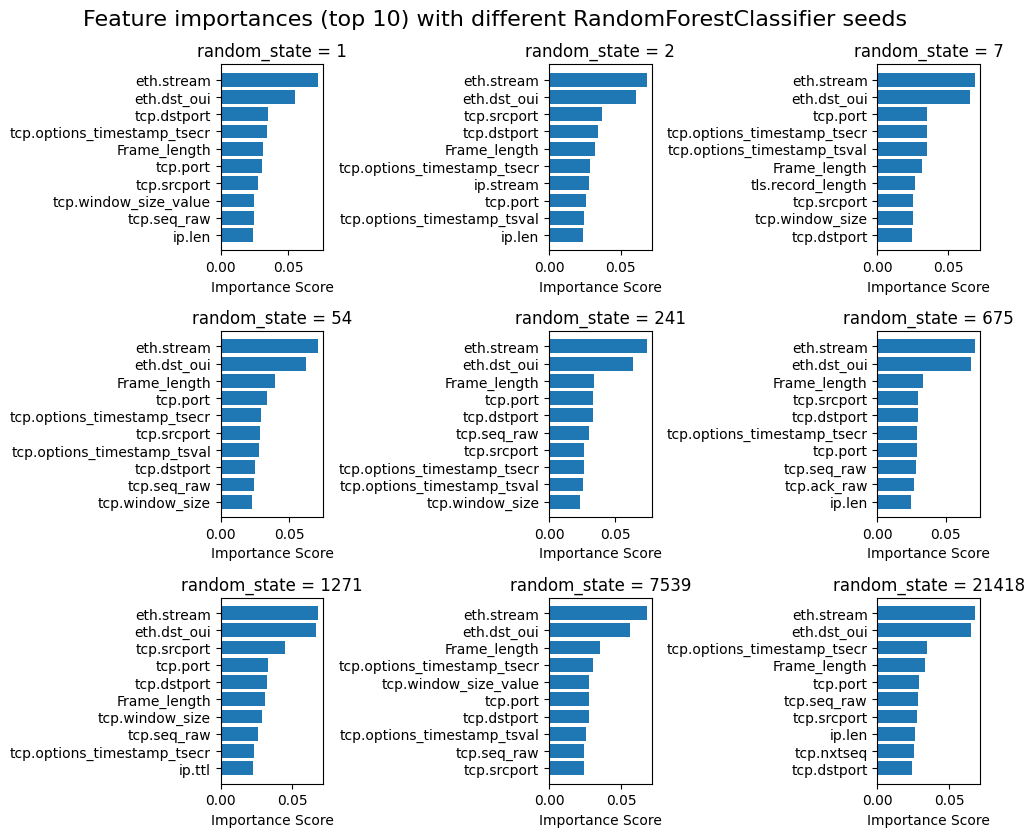

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

seeds = [1, 2, 7, 54, 241, 675, 1271, 7539, 21418] # Seeds for reproducibility
top_n = 10 # Use 10 most important features
all_importances = np.zeros((len(seeds), len(X.columns))) # Store importances with every seed to compute mean later

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 8.5))
fig.suptitle('Feature importances (top 10) with different RandomForestClassifier seeds', fontsize=16)

for i, seed in enumerate(seeds):

    # Train RandomForest with current seed
    rf = RandomForestClassifier(n_estimators=200, random_state=seed)
    rf.fit(X, y)
    
    # Get and sort feature importances
    importances = rf.feature_importances_
    all_importances[i] = importances
    sorted_idx = np.argsort(importances)[::-1][:top_n]
    sorted_importances = importances[sorted_idx]
    sorted_feature_names = [X.columns[j] for j in sorted_idx]
    
    # Select subplot (3x3 grid)
    ax = axes[i//3, i%3]
    
    # Plot horizontal bar chart
    ax.barh(range(len(sorted_feature_names)), sorted_importances)
    ax.set_yticks(range(len(sorted_feature_names)))
    ax.set_yticklabels(sorted_feature_names)
    ax.invert_yaxis() # Most important at top
    ax.set_xlabel('Importance Score')
    ax.set_title(f'random_state = {seed}')

plt.tight_layout()
plt.show()

Selected features:
 ['eth.stream', 'eth.dst_oui', 'Frame_length', 'tcp.port', 'tcp.srcport', 'tcp.options_timestamp_tsecr', 'tcp.dstport', 'tcp.seq_raw', 'tcp.options_timestamp_tsval', 'tcp.window_size']


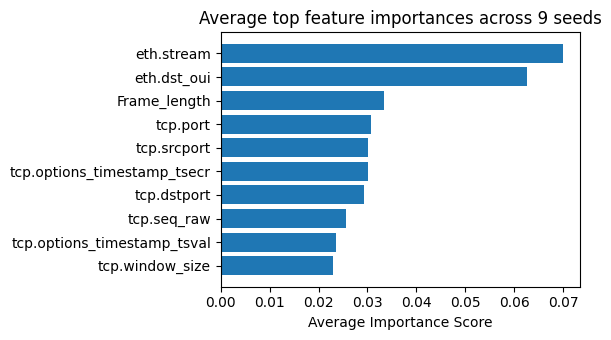

In [27]:
# Compute mean importances across seeds
mean_importances = np.mean(all_importances, axis=0)

# Sort features by mean importance (descending)
sorted_idx = np.argsort(mean_importances)[::-1][:top_n]
sorted_importances = mean_importances[sorted_idx]
sorted_feature_names = [X.columns[j] for j in sorted_idx]

print("Selected features:\n", sorted_feature_names)

# Plot the averaged importances
plt.figure(figsize=(6, 3.5))
std_importances = np.std(all_importances, axis=0)[sorted_idx]
plt.barh(range(len(sorted_feature_names)), sorted_importances)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.gca().invert_yaxis()
plt.xlabel('Average Importance Score')
plt.title('Average top feature importances across 9 seeds')
plt.tight_layout()
plt.show()